<a href="https://colab.research.google.com/github/ingimar-eyfjord/AAI_exam/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch import cuda
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import torchvision.transforms as transforms
import pandas as pd
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

train_on_gpu = cuda.is_available()

In [ ]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(size=224),  # Image net standards
    transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406],
#                              [0.229, 0.224, 0.225])  # Imagenet standards
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
valid_transform = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

In [ ]:
dataset = torchvision.datasets.CIFAR10(root='datasets/', download=True, transform=ToTensor())

train_set = torchvision.datasets.CIFAR10('./datasets', train=True,
                                         download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10('./datasets', train=False,
                                        download=True, transform=transform)

validation_set = torchvision.datasets.CIFAR10('./datasets', train=False,
                                        download=True, transform=valid_transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64,
                                           shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64,
                                          shuffle=False, num_workers=4)

validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=64,
                                          shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Iterate through the dataloader once
trainiter = iter(train_loader)
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [ ]:
dataset_size = len(train_set)
test_dataset_size = len(test_set)

print("Training dataset size", dataset_size)
print("Testing datasets size", test_dataset_size)

print(dataset)

Training dataset size 50000
Testing datasets size 10000
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: datasets/
    Split: Train
    StandardTransform
Transform: ToTensor()


In [ ]:
classes = dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
print(type(train_set[0][0][0][0]))

<class 'torch.Tensor'>


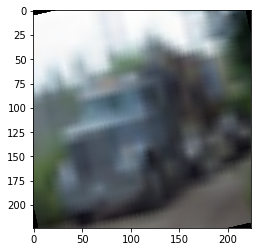

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()
    
image_iter = iter(train_loader)
images, _ = image_iter.next()
imshow(torchvision.utils.make_grid(images[:1], nrow=1))

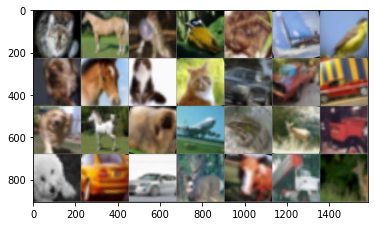

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()
    
image_iter = iter(train_loader)
images, _ = image_iter.next()
imshow(torchvision.utils.make_grid(images[:28], nrow=7))

In [ ]:
from torchvision import models

import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
# Freeze model weights
# for param in model.parameters():
#     param.requires_grad = False

In [ ]:
# print(model.classifier)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch.nn as nn
# We need to change the classifiers to fit to the cifar 10 dataset
model.classifier[4] = nn.Linear(4096,1024)
model.classifier[6] = nn.Linear(1024,10)

#  since the Alexnet has 1000 nodesat the output layer this must be changed to 10 i.e. the number of classes we have
# model.classifier[6] = nn.Sequential(
#                       nn.Linear(256*4*4, 1024), 
#                       nn.ReLU(), 
#                       nn.Dropout(0.4),
#                       nn.Linear(1024, 512),                   
#                       nn.LogSoftmax(dim=1))

# model.classifier[6] = nn.Sequential(
#                       nn.Flatten(), 
#                       nn.Linear(256*4*4, 1024),
#                       nn.ReLU(), 
#                       nn.Dropout(0.4),
#                       nn.Linear(1024, 512),
#                       nn.ReLU(),
#                       nn.Linear(512, 10),
#                       nn.LogSoftmax(dim=1))
# Add on classifier
# model.classifier[6] = nn.Sequential(
#             nn.Flatten(), 
#             nn.Linear(256*4*4, 1024),
#             nn.ReLU(),
#             nn.Linear(1024, 512),
#             nn.ReLU(),
#             nn.Linear(512, 10))

In [ ]:
# print(model.classifier)
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

44,428,106 total parameters.
44,428,106 training parameters.


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        gpu_count = cuda.device_count()
        print(f'Model will run on GPU, {gpu_count} gpus detected.')
        if gpu_count > 1:
            multi_gpu = True
        else:
            multi_gpu = False
        return torch.device('cuda')
    else:
        print("Model will run on, CPU")
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

Model will run on GPU, 1 gpus detected.


device(type='cuda')

In [ ]:
# Move to gpu
model = model.to('cuda')
# Distribute across 2 gpus
# model = nn.DataParallel(model)

In [ ]:
from torch import optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
# criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training of AlexNet')

Finished Training of AlexNet


In [ ]:
# for p in optimizer.param_groups[0]['params']:
#     if p.requires_grad:
#         print(p.shape)

In [ ]:
# # Timing utility
# from timeit import default_timer as timer
# def train(model,
#           criterion,
#           optimizer,
#           train_loader,
#           valid_loader,
#           save_file_name,
#           max_epochs_stop=3,
#           n_epochs=10,
#           print_every=1):
#     """Train a PyTorch Model

#     Params
#     --------
#         model (PyTorch model): cnn to train
#         criterion (PyTorch loss): objective to minimize
#         optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
#         train_loader (PyTorch dataloader): training dataloader to iterate through
#         valid_loader (PyTorch dataloader): validation dataloader used for early stopping
#         save_file_name (str ending in '.pt'): file path to save the model state dict
#         max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
#         n_epochs (int): maximum number of training epochs
#         print_every (int): frequency of epochs to print training stats

#     Returns
#     --------
#         model (PyTorch model): trained cnn with best weights
#         history (DataFrame): history of train and validation loss and accuracy
#     """

#     # Early stopping intialization
#     epochs_no_improve = 0
#     valid_loss_min = np.Inf

#     valid_max_acc = 0
#     history = []

#     # Number of epochs already trained (if using loaded in model weights)
#     try:
#         print(f'Model has been trained for: {model.epochs} epochs.\n')
#     except:
#         model.epochs = 0
#         print(f'Starting Training from Scratch.\n')

#     overall_start = timer()

#     # Main loop
#     for epoch in range(n_epochs):

#         # keep track of training and validation loss each epoch
#         train_loss = 0.0
#         valid_loss = 0.0

#         train_acc = 0
#         valid_acc = 0

#         # Set to training
#         model.train()
#         start = timer()

#         # Training loop
#         for ii, (data, target) in enumerate(train_loader):
#             # Tensors to gpu
#             if train_on_gpu:
#                 data, target = data.cuda(), target.cuda()

#             # Clear gradients
#             optimizer.zero_grad()
#             # Predicted outputs are log probabilities
#             output = model(data)

#             # Loss and backpropagation of gradients
#             loss = criterion(output, target)
#             loss.backward()

#             # Update the parameters
#             optimizer.step()

#             # Track train loss by multiplying average loss by number of examples in batch
#             train_loss += loss.item() * data.size(0)

#             # Calculate accuracy by finding max log probability
#             _, pred = torch.max(output, dim=1)
#             correct_tensor = pred.eq(target.data.view_as(pred))
#             # Need to convert correct tensor from int to float to average
#             accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
#             # Multiply average accuracy times the number of examples in batch
#             train_acc += accuracy.item() * data.size(0)

#             # Track training progress
#             print(
#                 f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
#                 end='\r')

#         # After training loops ends, start validation
#         else:
#             model.epochs += 1

#             # Don't need to keep track of gradients
#             with torch.no_grad():
#                 # Set to evaluation mode
#                 model.eval()

#                 # Validation loop
#                 for data, target in valid_loader:
#                     # Tensors to gpu
#                     if train_on_gpu:
#                         data, target = data.cuda(), target.cuda()

#                     # Forward pass
#                     output = model(data)

#                     # Validation loss
#                     loss = criterion(output, target)
#                     # Multiply average loss times the number of examples in batch
#                     valid_loss += loss.item() * data.size(0)

#                     # Calculate validation accuracy
#                     _, pred = torch.max(output, dim=1)
#                     correct_tensor = pred.eq(target.data.view_as(pred))
#                     accuracy = torch.mean(
#                         correct_tensor.type(torch.FloatTensor))
#                     # Multiply average accuracy times the number of examples
#                     valid_acc += accuracy.item() * data.size(0)

#                 # Calculate average losses
#                 train_loss = train_loss / len(train_loader.dataset)
#                 valid_loss = valid_loss / len(valid_loader.dataset)

#                 # Calculate average accuracy
#                 train_acc = train_acc / len(train_loader.dataset)
#                 valid_acc = valid_acc / len(valid_loader.dataset)

#                 history.append([train_loss, valid_loss, train_acc, valid_acc])

#                 # Print training and validation results
#                 if (epoch + 1) % print_every == 0:
#                     print(
#                         f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
#                     )
#                     print(
#                         f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
#                     )

#                 # Save the model if validation loss decreases
#                 if valid_loss < valid_loss_min:
#                     # Save model
#                     torch.save(model.state_dict(), save_file_name)
#                     # Track improvement
#                     epochs_no_improve = 0
#                     valid_loss_min = valid_loss
#                     valid_best_acc = valid_acc
#                     best_epoch = epoch

#                 # Otherwise increment count of epochs with no improvement
#                 else:
#                     epochs_no_improve += 1
#                     # Trigger early stopping
#                     if epochs_no_improve >= max_epochs_stop:
#                         print(
#                             f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
#                         )
#                         total_time = timer() - overall_start
#                         print(
#                             f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
#                         )

#                         # Load the best state dict
#                         model.load_state_dict(torch.load(save_file_name))
#                         # Attach the optimizer
#                         model.optimizer = optimizer

#                         # Format history
#                         history = pd.DataFrame(
#                             history,
#                             columns=[
#                                 'train_loss', 'valid_loss', 'train_acc',
#                                 'valid_acc'
#                             ])
#                         return model, history

#     # Attach the optimizer
#     model.optimizer = optimizer
#     # Record overall time and print out stats
#     total_time = timer() - overall_start
#     print(
#         f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
#     )
#     print(
#         f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
#     )
#     # Format history
#     history = pd.DataFrame(
#         history,
#         columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
#     return model, history

In [ ]:
# save_file_name = 'alexnet.pt'

# model, history = train(
#     model,
#     criterion,
#     optimizer,
#     train_loader,
#     validation_loader,
#     save_file_name=save_file_name,
#     max_epochs_stop=5,
#     n_epochs=10,
#     print_every=1)

In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

NameError: ignored

<Figure size 576x432 with 0 Axes>

In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

In [ ]:
#Testing Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 88 %


In [ ]:
#Testing classification accuracy for individual classes.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 98 %
Accuracy of automobile : 94 %
Accuracy of  bird : 86 %
Accuracy of   cat : 76 %
Accuracy of  deer : 76 %
Accuracy of   dog : 86 %
Accuracy of  frog : 96 %
Accuracy of horse : 87 %
Accuracy of  ship : 91 %
Accuracy of truck : 82 %


In [ ]:
avg = 0
for i in range(10):
  temp = (100 * class_correct[i] / class_total[i])
  avg = avg + temp
avg = avg/10
print('Average accuracy = ', avg)

Average accuracy =  87.51660420029168
